In [1]:
import numpy as np
import os
from random import randint, shuffle
from PIL import Image

import torch

import cv2 as cv

import util
from config import Config

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

/home/cheng/miniconda3/envs/visnet/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
model_folder = './'
cg = Config(os.path.join(model_folder, 'config.yaml'))

In [4]:

net = util.EvenCodeNet(config=cg)
if cg.compile:
    net = torch.compile(net)
# net.to(cg.device)

layer = net.layers[-1]
model_path = cg.fname_checkpoint.format(epoch=cg.n_epoch-1)
layer, _, _, _ = util.load_model(os.path.join(model_folder, model_path), layer)
layer.requires_grad_(False)

net.eval()

Loading model from ./checkpoint_epoch_4.pt


EvenCodeNet(
  (layers): ModuleList(
    (0): ParallelMLPConv2d(
      (funapp): ParallelMLP(
        (hidden): ModuleList(
          (0): ParallelLinear(in_features=75, out_features=48, out_channels=96, bias=True)
        )
        (out): ParallelLinear(in_features=48, out_features=1, out_channels=96, bias=True)
      )
      (unfold): Unfold(kernel_size=[5, 5], dilation=1, padding=0, stride=[1, 1])
    )
  )
)

In [5]:
# filename = './test_images/1920px-Visible_spectrum_390-710_nm_linear_perceptual.png'
filename = './test_images/German_BMW_Police_Car_in_Munich_small.jpg'
# img = Image.open(filename).convert('L') # gray
img = Image.open(filename).convert('RGB') # color 
img = np.array(img)
img = img.transpose((2, 0, 1)) # color
img = img.astype(np.float32)
img = img / 255
# img = np.stack([img]*4)

In [6]:
img.shape

(3, 907, 1209)

(np.float64(-0.5), np.float64(1208.5), np.float64(906.5), np.float64(-0.5))

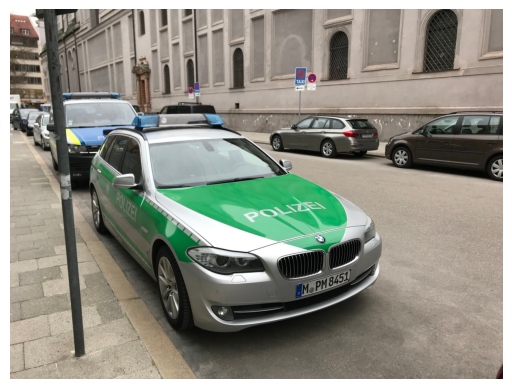

In [7]:
# plt.figure(figsize = (10,10))
plt.imshow(img.transpose((1, 2, 0)), vmin=0, vmax=1) # color
# plt.imshow(img, vmin=0, vmax=1, cmap='gray') # gray
plt.axis('off')

In [8]:
input = img[None, :]
# input = img[None, None, :] # gray
input = torch.from_numpy(input).float()
output = net(input)
output = torch.round(output).numpy()
output.shape

(1, 96, 903, 1205)

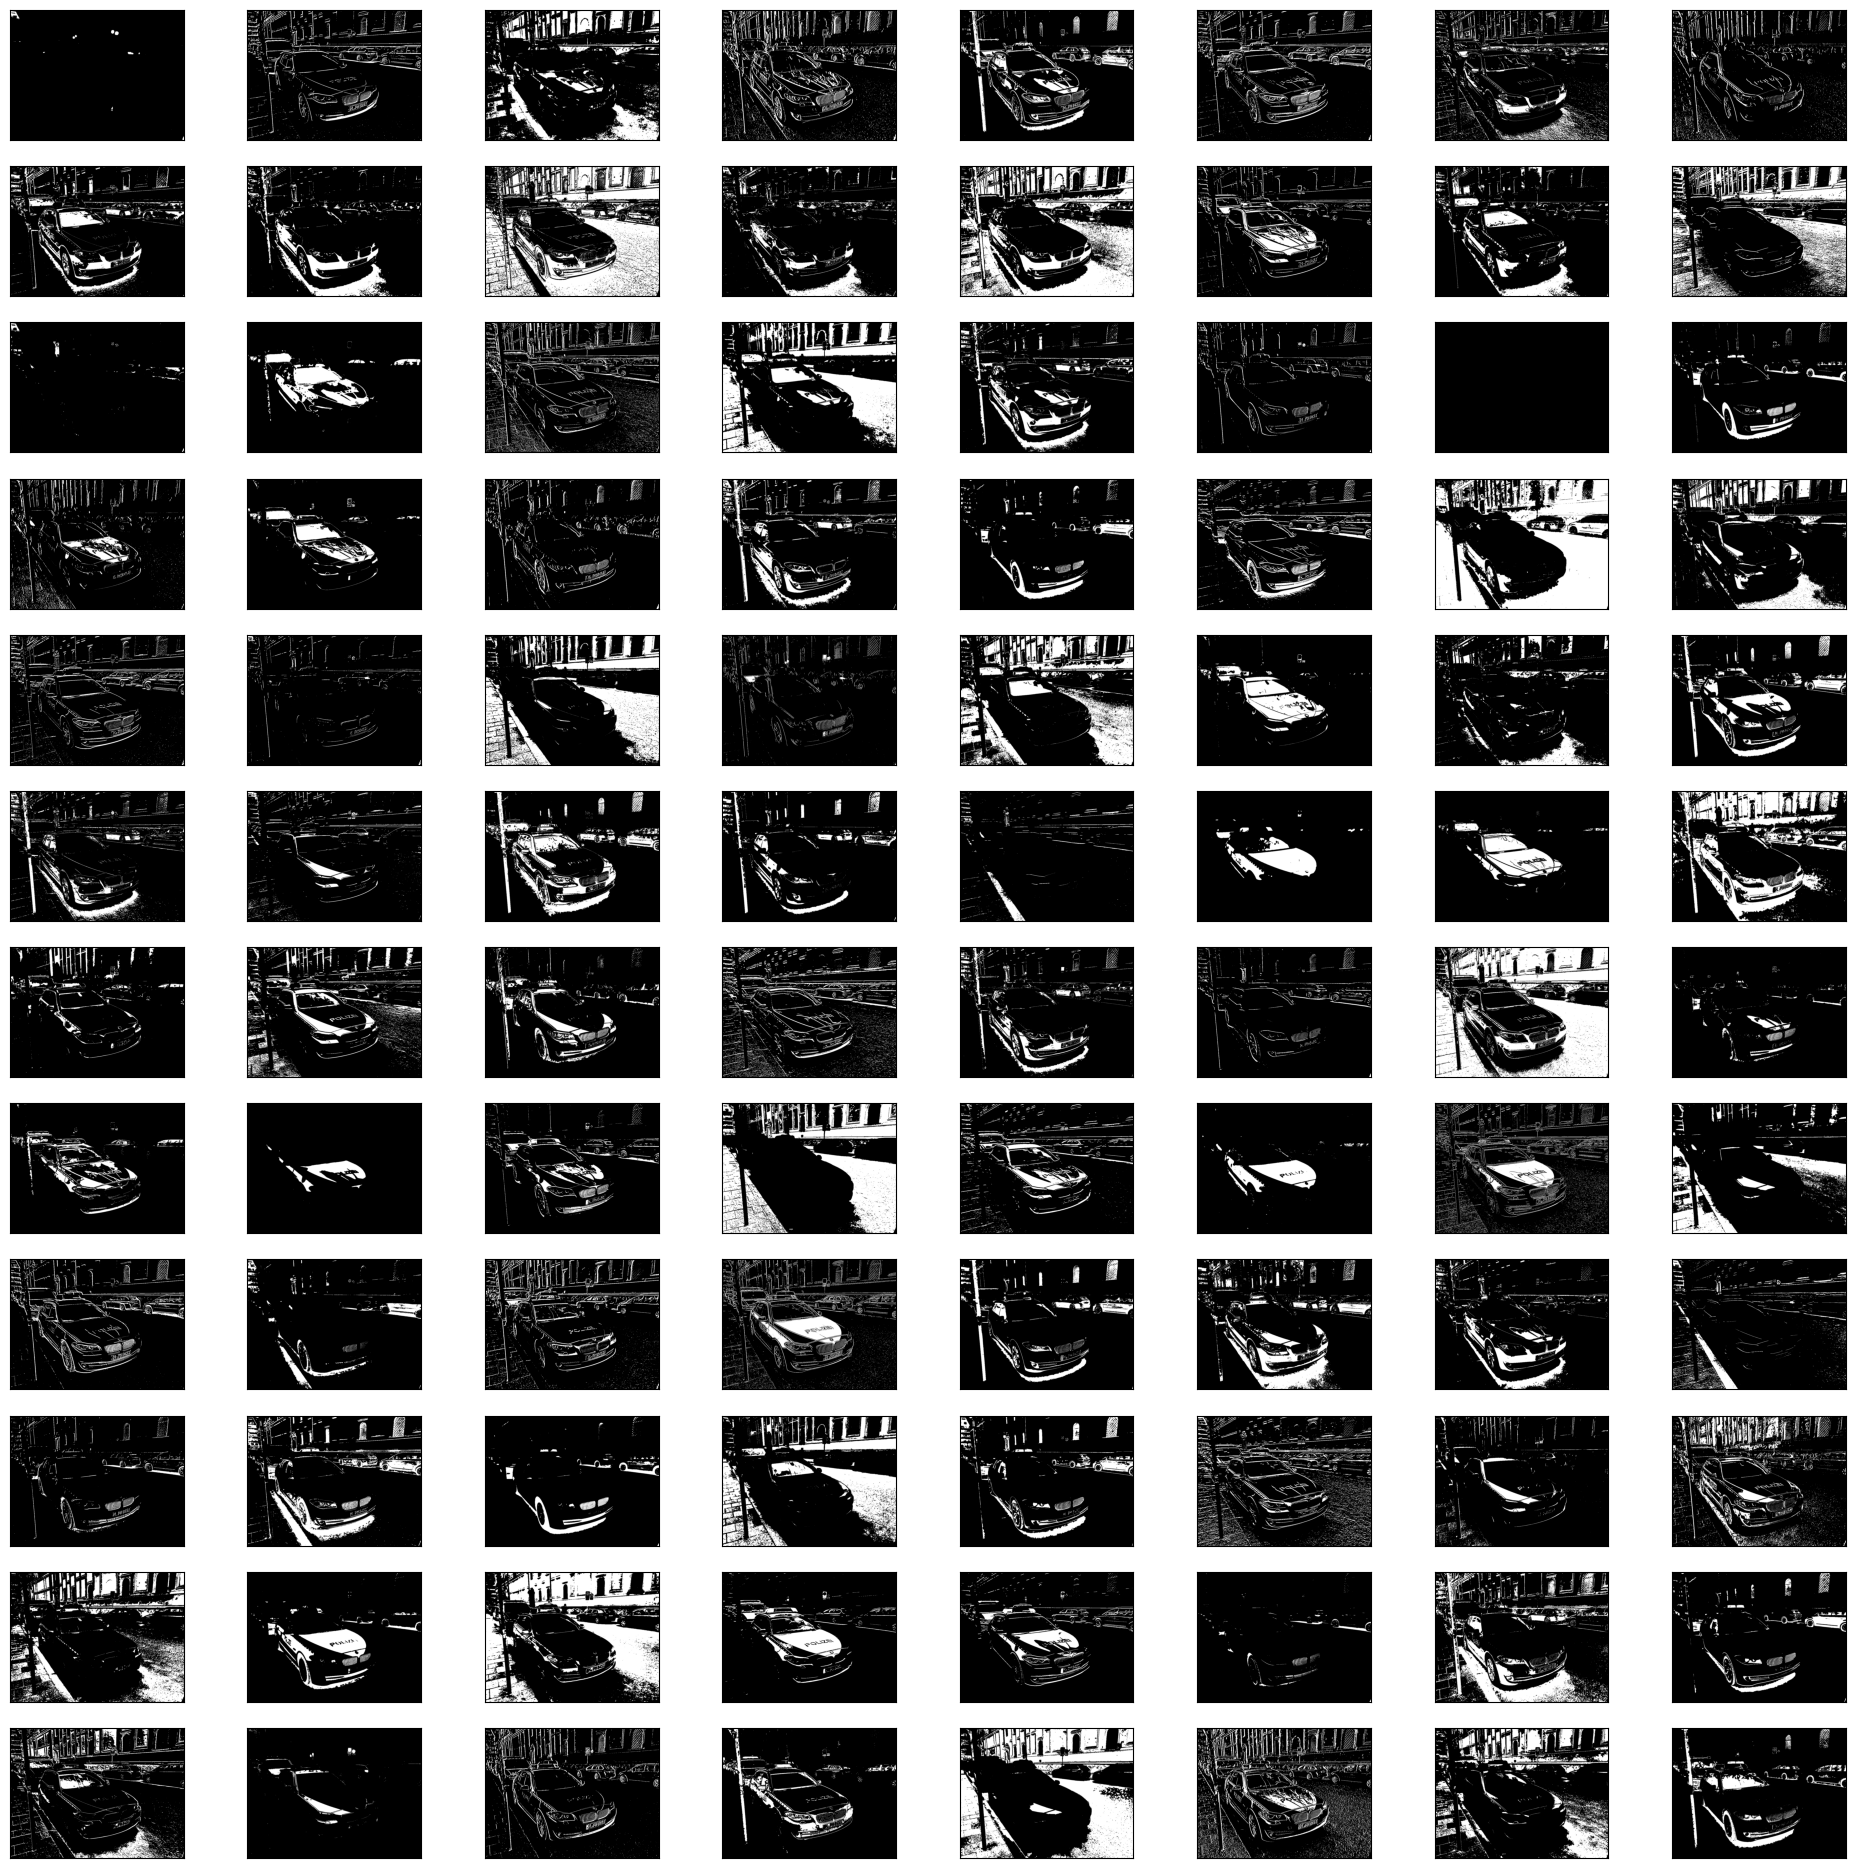

In [9]:
nrows = 12
ncols = 8
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(24, 24))
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        # ax.set_axis_off()
        # ax.axis('off')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.imshow(output[0][i*ncols + j], vmin=0, vmax=1, cmap='gray')
